In [7]:
# from google.colab import drive
# drive.mount("/content/d")

Drive already mounted at /content/d; to attempt to forcibly remount, call drive.mount("/content/d", force_remount=True).


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [9]:
# fPath = "d/MyDrive/iftm_nlp/data_kaggle/"
fPath = "/data/kaggle_unit_3/"
df = pd.read_csv(fPath + "train.csv")

# drop rows with empty target
df = df[~df.Sentiment.isna()].reset_index(drop=True)
df.drop("Unnamed: 0", axis=1, inplace=True)

print(df.shape)
df.head(3)

(41155, 2)


,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive


## preprocess

{'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


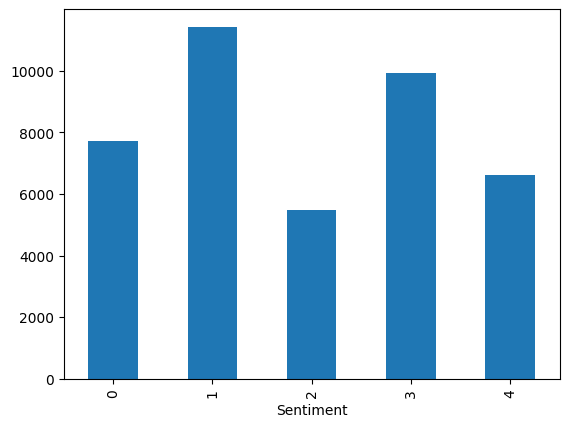

In [10]:
# encoding string labels
no_labels = df.Sentiment.nunique()
labels_dict = dict(zip(df.Sentiment.unique(), range(no_labels)))
print(labels_dict)
df.Sentiment = df.Sentiment.map(labels_dict)

# check the target ditribution
ax = df.groupby("Sentiment").count().plot(kind="bar", legend=False)

In [11]:
# clean the text

def remove_links(v):
    # remove https links
    return re.sub(r"https\S+","", v)

def remove_calls(v):
    # remove @text
    return re.sub(r"@\S+","", v)

def remove_punctuation(v):
    # remove special chars
    return re.sub(f"[{re.escape(string.punctuation)}]", '', v)

def remove_chars(v):
    # remove special chars
    chars = ["\n", "\t", "\r", "<br>"]
    for char in chars:
        v = v.replace(char, "")
    return v

def remove_digits(v):
    # remove digits
    return re.sub(r"\d", "", v)

def remove_emojis(data):
    # remove emojis
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


df.Text = df.Text.apply(remove_links)
df.Text = df.Text.apply(remove_calls)
df.Text = df.Text.apply(remove_punctuation)
df.Text = df.Text.apply(remove_chars)
df.Text = df.Text.apply(remove_digits)
df.Text = df.Text.apply(remove_emojis)

# lower the text
df.Text = df.Text.str.lower()
# remove rows with the text too short
min_text_len = 20
df = df[~df.Text.str.len()<min_text_len].reset_index(drop=True)
print("preprocess completed")

preprocess completed


## convert to vectors

In [6]:
max_words = 40_000
max_sequence_length = 1024

# tokenize words
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.Text)
sequences = tokenizer.texts_to_sequences(df.Text)
word_index = tokenizer.word_index

# vectors padding
x = pad_sequences(sequences, maxlen=max_sequence_length)
# target ohe
y = to_categorical(df.Sentiment, num_classes=5)
print(x.shape, y.shape)

(41155, 1024) (41155, 5)


In [ ]:
# input scaling
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [ ]:
# train test split
xtr, xvl, ytr, yvl = train_test_split(x, y, test_size=0.2, random_state=42)

## model_fit

In [ ]:
# Define the LSTM model
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    x, y,
    epochs=10,
    batch_size=32,
    validation_data=(xvl, yvl)
)

Epoch 1/10
1287/1287 [==============================] - 51s 37ms/step - loss: 1.5775 - accuracy: 0.2756 - val_loss: 1.5740 - val_accuracy: 0.2799
Epoch 2/10
1287/1287 [==============================] - 46s 36ms/step - loss: 1.5761 - accuracy: 0.2773 - val_loss: 1.5739 - val_accuracy: 0.2799
Epoch 3/10
1287/1287 [==============================] - 48s 37ms/step - loss: 1.5756 - accuracy: 0.2776 - val_loss: 1.5758 - val_accuracy: 0.2799
Epoch 4/10
1287/1287 [==============================] - 48s 38ms/step - loss: 1.5761 - accuracy: 0.2775 - val_loss: 1.5747 - val_accuracy: 0.2799
Epoch 5/10
1287/1287 [==============================] - 47s 37ms/step - loss: 1.5757 - accuracy: 0.2771 - val_loss: 1.5739 - val_accuracy: 0.2799
Epoch 6/10
1287/1287 [==============================] - 46s 36ms/step - loss: 1.5755 - accuracy: 0.2774 - val_loss: 1.5745 - val_accuracy: 0.2799
Epoch 7/10
1287/1287 [==============================] - 47s 36ms/step - loss: 1.5758 - accuracy: 0.2775 - val_loss: 1.5745 -

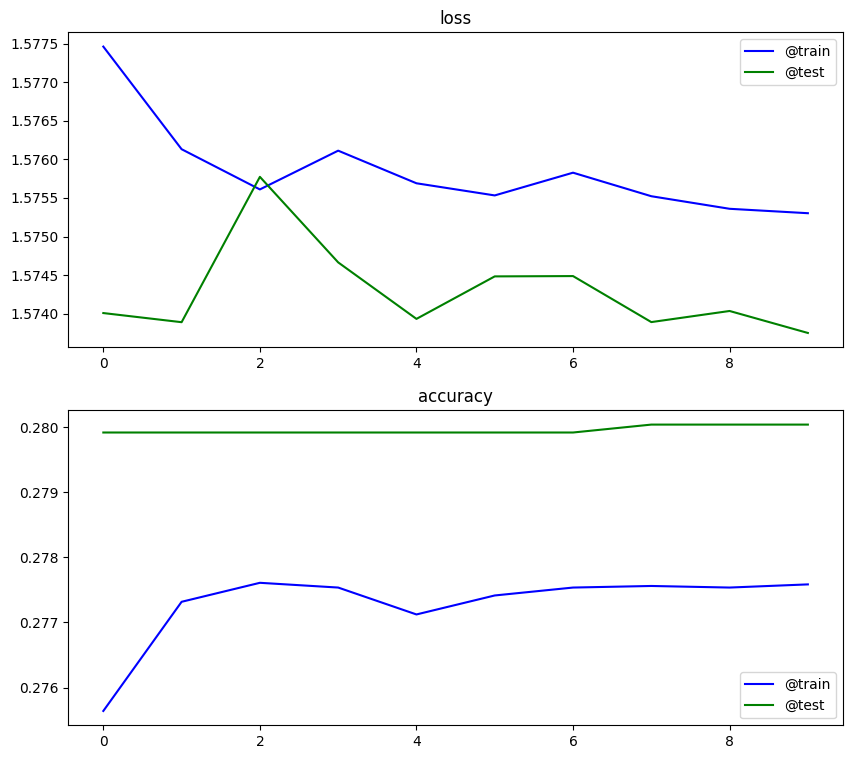

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color="b", label="@train")
plt.plot(history.history["val_loss"], color="g", label="@test")
plt.title("loss")
plt.legend();

plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color="b", label="@train")
plt.plot(history.history["val_accuracy"], color="g", label="@test")
plt.title("accuracy")
plt.legend();

## predict & submit

In [ ]:
# preprocess test

dfts = pd.read_csv(fPath + "test.csv")

dfts.Text = dfts.Text.apply(remove_links)
dfts.Text = dfts.Text.apply(remove_calls)
dfts.Text = dfts.Text.apply(remove_punctuation)
dfts.Text = dfts.Text.apply(remove_chars)
dfts.Text = dfts.Text.apply(remove_digits)
dfts.Text = dfts.Text.apply(remove_emojis)

# lower the text
dfts.Text = dfts.Text.str.lower()
# remove rows with the text too short
min_text_len = 20
dfts = dfts[~dfts.Text.str.len()<min_text_len].reset_index(drop=True)
print("preprocess completed")

preprocess completed


In [ ]:
# predict
sequences = tokenizer.texts_to_sequences(dfts.Text)
xts = pad_sequences(sequences, maxlen=max_sequence_length)
predictions = model.predict(xts)
predictions = np.argmax(predictions, axis=1)

119/119 [==============================] - 2s 14ms/step


In [ ]:
# decode labels
decode_labels_dict = {k:v for v,k in labels_dict.items()}
predictions = [decode_labels_dict[x] for x in predictions]

In [ ]:
# submit
submission = pd.read_csv(fPath + "sample_submission.csv")
submission.Sentiment = predictions
submission.to_csv("submission.csv", index=False)

# import os
# os.environ["KAGGLE_USERNAME"]=
# os.environ["KAGGLE_KEY"]=

!kaggle competitions submit -c unit-3-nlp-txt-classification -f submission.csv -m "*"

100% 181k/181k [00:02<00:00, 67.1kB/s]
Successfully submitted to Unit 3 - Классификация текстов